# True Reach Estimator

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

## TRIAL 5 - Label Encoding

Convert comments into bins to adjust this feature. 

In previous trials the coefficient of our 'comments' feature was often negative. Additionally, when visualizing a scatter plot of our comments versus reach we did not see an obvious correlation. The data points were clustered in a curve near the x-y axis. 

Label encoding will allow us to assign bins to the data and weight them appropriately. We will use this to tansform the coefficient and potentially help our regression become less effected by the 'Comments' field.

To begin we will use data that has already been grouped by user. There is a single row for each instagram user and the data that follows is the mean of the combined values. 

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

Pull in the CSV file

In [2]:
df = pd.read_csv('trial_4_groupby.csv')

Drop columns that are unneeded.

In [3]:
df = df.drop(['Unnamed: 0'], axis=1)

**Early Data Cleaning**

Anyone with very little reach will skew the  data. It's probably a bot. 

In [4]:
df = df[(df['reach']>300)]

We have decided to remove rows that have less than 100 followers. This not only helps eliminate outliers but in the data collection there were many rows with zero followers and high numbers in reach. This data clearly is not correct 

In [5]:
df = df[(df['followers']>1000)]

Setting comments to greater than zero to avoid zero division errors

In [6]:
df = df[(df['comments']>=1)]

Remove rows with less than 100 likes to eliminate outliers.

In [7]:
df = df[(df['likes']>=100)]

Remove wierd situations where there are more comments, likes than reach.

In [8]:
df = df.loc[(df.likes<df.reach)]
df = df.loc[(df.comments<df.reach)]

Next we look at full correlation. The test here is to make sure that any two of our variables aren't so correlated that the account for the same effect on the dependent variable.

We then created a heat map of the correation numbers to better see which variables we can use. 

In [9]:
df.corr()

,followers,likes,comments,impressions,reach
followers,1.000000,0.710528,0.422634,0.675025,0.667567
likes,0.710528,1.000000,0.578168,0.871982,0.852839
comments,0.422634,0.578168,1.000000,0.489588,0.480532
impressions,0.675025,0.871982,0.489588,1.000000,0.995562
reach,0.667567,0.852839,0.480532,0.995562,1.000000


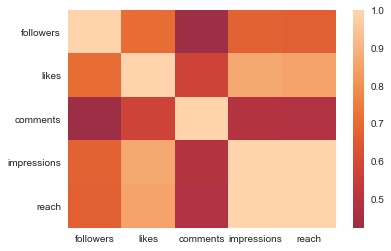

In [10]:
sns.heatmap(df.corr(), center=0);

Curious to see the time frame of these records. 

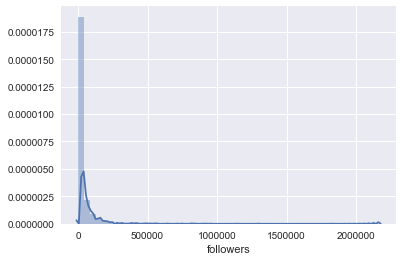

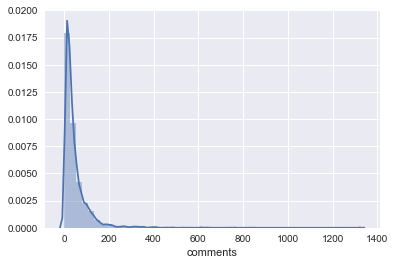

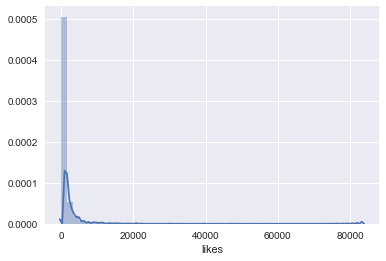

In [11]:
# fig, axs = plt.subplots(1,3, squeeze=False)

sns.distplot(df.followers)
plt.show()
sns.distplot(df.comments)
plt.show()
sns.distplot(df.likes)
plt.show()

# Perform Label Encoding

To begin we use the .describe() method in pandas to show us the descriptive statistics. We will use the min, max, and inter-quartile range to set our bins. 

In [12]:
df.comments.describe()

count    3568.000000
mean       48.843610
std        67.200512
min         1.000000
25%        15.000000
50%        29.000000
75%        57.000000
max      1322.000000
Name: comments, dtype: float64

In [13]:
bins = [0, 15, 29, 57, 1322]
# use pd.cut
bins_comments = pd.cut(df['comments'], bins)

In [14]:
bins_comments = bins_comments.cat.as_unordered()
bins_comments.head()

0    (57, 1322]
1       (0, 15]
2    (57, 1322]
3      (29, 57]
4    (57, 1322]
Name: comments, dtype: category
Categories (4, interval[int64]): [(0, 15], (15, 29], (29, 57], (57, 1322]]

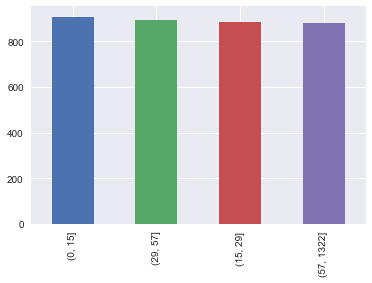

In [15]:
 bins_comments.value_counts().plot(kind='bar')

In [16]:
df['comments'] = bins_comments

In [17]:
df['comments'] = df['comments'].cat.codes

In [18]:
df.head(10)

,followers,likes,comments,impressions,reach
0,100276.0,1472.0,3,6209.0,5302.0
1,10299.0,562.0,0,710.0,574.0
2,40025.0,1600.0,3,3371.0,2789.0
3,22071.0,807.0,2,11333.0,8932.0
4,24390.0,1467.0,3,6198.0,4824.0
5,6148.0,427.0,1,3053.0,2363.0
7,31816.0,294.0,2,2502.0,2066.0
9,177884.0,2051.0,3,3583.0,2963.0
11,387851.0,7550.0,3,94846.0,70933.0
12,37813.0,801.0,2,11163.0,9188.0


In [19]:
dummies = pd.get_dummies(df['comments'], drop_first=True) #

In [20]:
dummies.head()

,1,2,3
0,0,0,1
1,0,0,0
2,0,0,1
3,0,1,0
4,0,0,1


In [21]:
dummies.columns= ['comments1', 'comments2', 'comments3']

In [22]:
df = pd.concat([df, dummies], axis=1)

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

Text(0.5, 1.0, 'Followers Correlation plot')

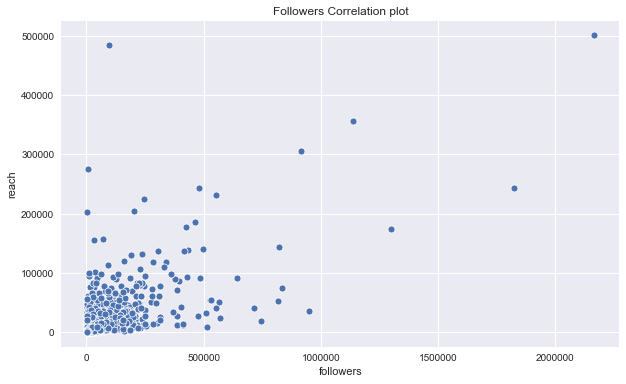

In [23]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df.followers, y=df.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")
# plt.xlim(0,75_000)
# plt.ylim(0, 1_000_000)

Cut all rows with more that 75,000 followers. 

Text(0.5, 1.0, 'Likes Correlation plot')

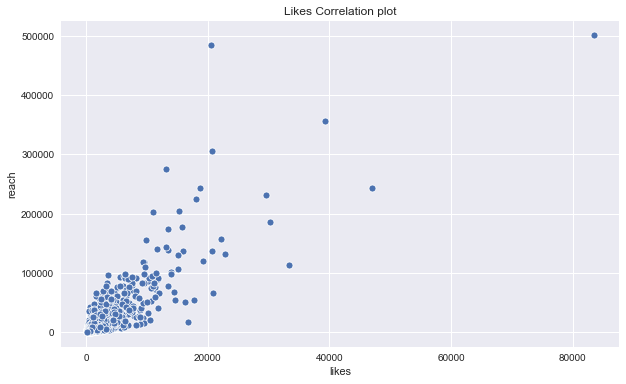

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df.reach, x=df.likes)
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Cut all rows with more that 75,000 likes 

Text(0.5, 1.0, ' Comments Correlation plot')

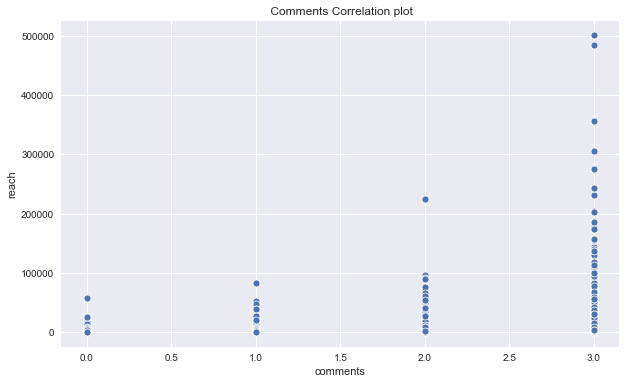

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df.reach, x=df.comments)
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

Based on the scatter plots we have decided to cut all users with more than 10,000 comments, 

In [26]:
abs(df.corr()) > 0.8

,followers,likes,comments,impressions,reach,comments1,comments2,comments3
followers,True,False,False,False,False,False,False,False
likes,False,True,False,True,True,False,False,False
comments,False,False,True,False,False,False,False,False
impressions,False,True,False,True,True,False,False,False
reach,False,True,False,True,True,False,False,False
comments1,False,False,False,False,False,True,False,False
comments2,False,False,False,False,False,False,True,False
comments3,False,False,False,False,False,False,False,True


Save clean CSV to new file for use on other notebooks.

In [27]:
# df2.to_csv('clean_instagram_train.csv')
# test.to_csv('clean_instagran_test.csv')

In [28]:
lr_model = ols(formula='reach~followers + likes + C(comments)', data=df).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     1976.
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:02:41   Log-Likelihood:                -38559.
No. Observations:                3568   AIC:                         7.713e+04
Df Residuals:                    3562   BIC:                         7.717e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -153.2442    397.925     -0.385      0.700    -933.427     626.939
C(comments)[T.1]   -36.5232    565.092     -0.065      0.948   -1144.460    1071.414
C(comments)[T.2]   103.3595    565.653      0.183      0.855   -1005.677    1212.396
C(comments)[T.3]    53.9989    602.015      0.090      0.929   -1126.330    1234.327
followers            0.0332      0.003     10.143      0.000       0.027       0.040
likes                6.3817      0.106     60.281      0.000       6.174       6.589
==============================================================================
Omnibus:                     5544.706   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9181749.810
Skew:                           9.219   Prob(JB):                         0.00
Kurtosis:                     250.832   Cond. No.                     4.12e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Finding:**: The model with a comments binned isn't significantly better than other trials. 

### Add Test Reach to the original data Frame to check for accuracy

In [29]:
df['test_reach'] = lr_model.predict(df)

In [30]:
df['reach_diff'] =  df['test_reach'] - df['reach']

In [31]:
df['diff_ratio'] = (df.reach_diff / df.reach)*100

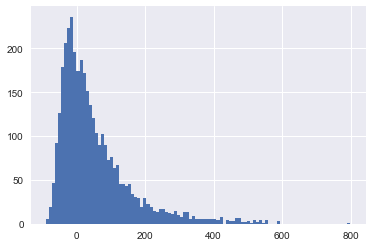

In [32]:
x = plt.hist(df.diff_ratio, bins = 100)

In [33]:
mean_squared_error(df.reach, df.test_reach)**.5

11945.033995251164

In [34]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df["likes"].values.reshape(-1, 1)
comments = df["comments"].values.reshape(-1, 1)
followers = df["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df["reach"])
regression_2.fit(comments, df["reach"])
regression_3.fit(followers, df["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[7.12297525]
[6029.50618353]
[0.17829608]


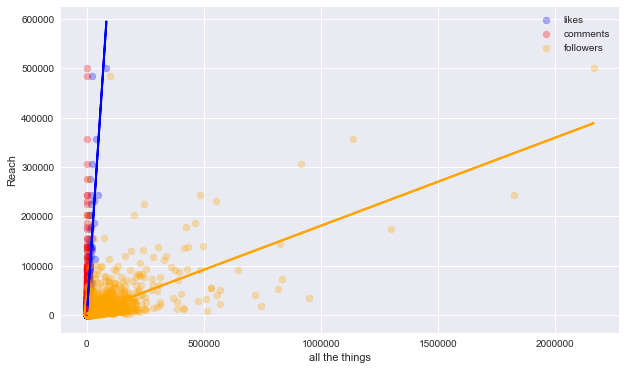

In [35]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df["reach"],  color='blue', alpha = 0.3, label = "likes")
plt.scatter(comments, df["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='orange', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")

plt.legend();

## Summary of Trial 5 - Label Encoding

Label encoding of our comments feature created a scatterplot that seemed to be able to better add to our coefficients. However, our R-Squared remained near .73 and our Root Mean Square Error of this trial is very large. 